In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.fundamental import chain_outlier, get_focus_tickers, train_on_winners
from utils.pricing import load_px_close, get_return_intervals 
from utils.pricing import dummy_col, discret_rets, sample_wgts
from utils.pricing import px_mom_feats, px_mom_co_feats_light, px_fwd_rets, get_ind_index
from utils.pricing import eq_wgt_indices, to_index_form, rename_col

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
import time, os, sys
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context data

In [762]:
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-technicals-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': [20,60,90],
    'look_back': 252*3,
    'load_ds': True,
    'scale': True,
    'test_size': .2,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 850,
    'max_iter': 20,
    'l2_reg': 0.01,
}

In [763]:
# get latest pricing file from inferece server
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB   6.5MB/s   00:02    


In [764]:
# load stored pricing
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
clean_co_px = px_close.dropna(subset=[bench])[tickers].fillna(method='ffill')

cut_range = get_return_intervals(
    clean_co_px, 
    int(np.mean(context['look_ahead'])), 
    tresholds=[0.25, 0.75])

print(f'Return intervals {np.round(cut_range, 3)}')

<class 'pandas.core.frame.DataFrame'>
Index: 4673 entries, 2004-05-16 to 2019-05-16
Columns: 1291 entries, 0700.HK to KRW=X
dtypes: float32(1291)
memory usage: 23.0+ MB
px_close.info() None
Return intervals [  -inf -0.127 -0.081  0.092  0.157    inf]


In [765]:
# latest quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-16
Loading file quote/csv/2019-05-16
Loading file summary-categories/assetProfile


In [766]:
# Smaller subset for testing
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

# size_df = get_focus_tickers(quotes, profile, tgt_sectors)
# tickers = list(size_df.index)
# ind_count = size_df.groupby('industry').count()['marketCap']
# tgt_industries = list(ind_count.loc[ind_count > ind_count.median() - 1].index)
# tickers = list(profile.loc[profile.industry.isin(tgt_industries), 'symbol'])
tickers = list(quotes.loc[quotes.quoteType == 'EQUITY', 'symbol'])
context['tickers'] = tickers
print(f'{len(tickers)} companies')

1214 companies


### Final

In [767]:
def pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    joined_df = pd.concat(super_list, axis=0)
    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
#     joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    joined_df.dropna(inplace=True)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

In [768]:
def get_train_test_sets(context):
    
    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    trained_cols = context['trained_cols']    
    test_size = context['test_size']    
    look_ahead = context['look_ahead']

    narrow_list = list(train_on_winners(clean_co_px, context['tickers'], 10, 0.75).index)
    context['tickers'] = narrow_list
    print(f'Training on {len(context["tickers"])} companies')

    joined_df = pre_process_ds(context)

    # calculation of forward returns
    Y = clean_co_px.apply(lambda x: px_fwd_rets(x, '', periods=[20, 60, 120]))
    Y = Y.rolling(int(np.mean(context['look_ahead']))).mean() # 
    Y = Y[~(Y.isna().all(1))]
    Y = Y.loc[joined_df.index.unique(), :]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break
          
    return X_train, X_test, y_train, y_test

In [769]:
def train_ds(context):
    
    X_train, X_test, y_train, y_test = get_train_test_sets(context)
    
    # Keras Model
    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    units = context['units']
    trained_cols = context['trained_cols']

    y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
    y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    # model.add(Dropout(0.05))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(int(units/2), activation='relu'))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
    keras.regularizers.l2(l2_reg)

    opt = Adam()
    # opt = Nadam() #essentially RMSprop with momentum, Nadam is Adam RMSprop with Nesterov momentum
    # opt = RMSprop() #optimizer is usually a good choice for recurrent neural networks

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('micro-train.log')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)    
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train_oh, validation_data=(X_test, y_test_oh), 
              epochs=max_iter, batch_size=200, callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

    # save model to drive
    model.save(fname)
    print('Saved ', fname)

In [770]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    
    look_back = context['look_back']
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    

    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'    
    
    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Train

In [771]:
max_iter = context['max_iter']
l2_reg = context['l2_reg']
units = context['units']
trained_cols = context['trained_cols']

X_train, X_test, y_train, y_test = get_train_test_sets(context)

y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

Training on 249 companies
Sectors: 11, Industries: 83


0it [00:00, ?it/s]/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
4it [00:00, 15.93it/s]

9984.T missing profile, skipping


10it [00:00, 13.51it/s]

ABMD missing profile, skipping


126it [00:11, 12.65it/s]

JBT missing profile, skipping


138it [00:12, 12.50it/s]

LRCX missing profile, skipping


178it [00:16, 11.12it/s]

ODFL missing profile, skipping


192it [00:17, 12.79it/s]

REGN missing profile, skipping


198it [00:17, 13.42it/s]

ROP missing profile, skipping


233it [00:20, 12.39it/s]

ULTI missing profile, skipping


249it [00:22, 11.45it/s]
/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (3723893, 1)
joined_df.shape (824478, 28)


/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (819581, 29)
neutral   0.53
long      0.18
bull      0.17
bear      0.07
short     0.05
Name: fwdReturn, dtype: float64
Training for 3605 dates, 14.3 years


In [ ]:
# Keras Model
model = Sequential()
model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dropout(0.05))
model.add(Dense(units, activation='relu'))
model.add(Dense(units, activation='relu'))
model.add(Dense(units, activation='relu'))
model.add(Dense(int(units/2), activation='relu'))
model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
keras.regularizers.l2(l2_reg)

opt = Adam()

ml_path, model_name = context['ml_path'], context['model_name']
fname = ml_path + model_name
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
csv_logger = CSVLogger('micro-train.log')

# save training columns
np.save(ml_path + trained_cols, X_train.columns) # save feature order
print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
print('Saved: ', ml_path + trained_cols)    

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train_oh, validation_data=(X_test, y_test_oh), 
          epochs=max_iter, batch_size=200, callbacks=[es, checkpointer, csv_logger])

score = model.evaluate(X_test, y_test_oh)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

In [ ]:
%time train_ds(context)

#### Predict

In [204]:
# predict for all
%time pred_df = predict_ds(context)

pred_X.shape (294782, 29)
pred_X.shape (294782, 29)
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-15.csv
CPU times: user 37.6 s, sys: 8.68 s, total: 46.3 s
Wall time: 34.7 s


#### Store / Read S3

In [15]:
s3_path = context['s3_path']

In [16]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tgt_date}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [17]:
ml_path = context['ml_path']
model_name = context['model_name']
trained_cols = context['trained_cols']

joined_df = pre_process_ds(context)

Sectors: 11, Industries: 135


0it [00:00, ?it/s]/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
5it [00:00, 16.16it/s]

9984.T missing profile, skipping


18it [00:01, 13.53it/s]

ABMD missing profile, skipping


195it [00:15, 12.84it/s]

CBOE missing profile, skipping


305it [00:24, 14.48it/s]

DDD missing profile, skipping


331it [00:26, 13.82it/s]

DRE missing profile, skipping


534it [00:43, 14.65it/s]

IBKR missing profile, skipping


584it [00:48, 11.81it/s]

JBT missing profile, skipping


652it [00:54, 12.32it/s]

LRCX missing profile, skipping


730it [01:00, 13.20it/s]

MU missing profile, skipping


798it [01:06, 14.46it/s]

ODFL missing profile, skipping


893it [01:14, 13.49it/s]

REGN missing profile, skipping


919it [01:16, 13.68it/s]

ROP missing profile, skipping


1018it [01:24, 13.61it/s]

TAP missing profile, skipping


1092it [01:30, 14.33it/s]

UDR missing profile, skipping


1099it [01:31, 13.81it/s]

ULTI missing profile, skipping


1176it [01:37, 13.19it/s]

WSM missing profile, skipping


1214it [01:40, 17.07it/s]


In [20]:
look_back = context['look_back']
pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
print('pred_X.shape', pred_X.shape)

# ensure prediction dataset is consistent with trained model
train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
missing_cols = [x for x in train_cols if x not in pred_X.columns]
if len(missing_cols):
    print(f'Warning missing columns: {missing_cols}')
    pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
    pred_X[missing_cols] = 0

sorted_cols = list(np.append(train_cols, ['symbol']))
print('pred_X.shape', pred_X[sorted_cols].shape)

pred_df = pd.DataFrame()
pred_df['symbol'] = pred_X.symbol

# Load model    
fname = ml_path + model_name
model = load_model(fname)
print('Loaded', fname)

preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    

pred_df['pred_class'] = preds_classes
pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
probs = np.round(preds,3)
pred_prob = np.argmax(probs, axis=1)
pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
pred_df.index.name = 'pred_date'

pred_X.shape (1387480, 29)
pred_X.shape (1387480, 29)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5


In [21]:
# recommendation distribution
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

neutral   0.63
long      0.14
bull      0.12
bear      0.06
short     0.04
Name: pred_label, dtype: float64

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


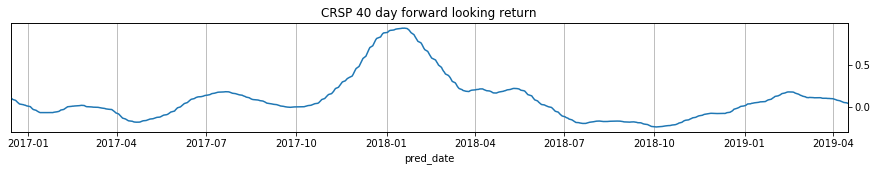

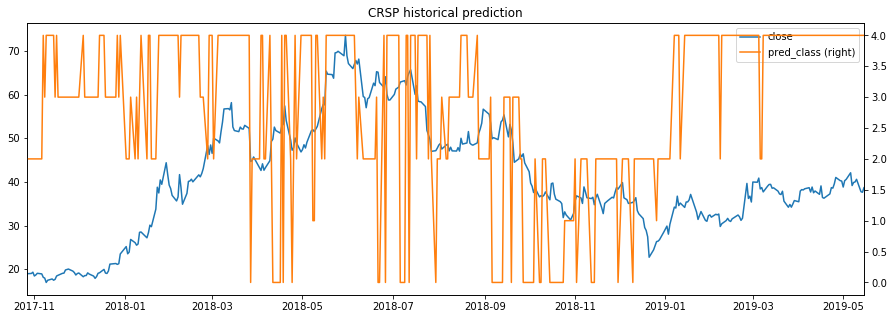

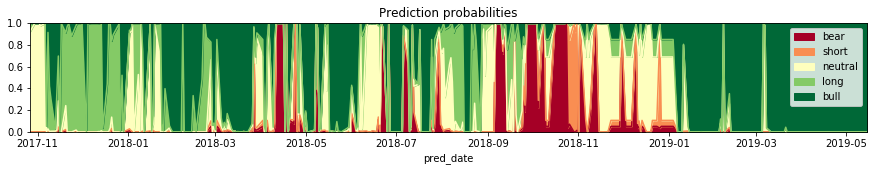

In [761]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    pct_chg_df = px_fwd_rets(
        px_df, pred_symbol, periods=context["look_ahead"])\
        .rolling(int(np.mean(context["look_ahead"]))).mean()
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + fwd_ret_labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True, secondary_y='pct_chg')

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[fwd_ret_labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)
    
plot_symbol_hist_pred('CRSP', clean_co_px, context, pred_df)

In [749]:
stop_loss = False
long = True
max_loss = 0.1
as_of_date = -1
study_period = -10
holding_period = 20
# range = [study_period + as_of_date:as_of_date]
min_confidence = 0.8
max_class_rows = 50
pred_classes = [3, 4] if long else [0, 1]

def get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    top_pred = pred_df.loc[(pred_df.index == pred_df.index.unique()[as_of_date]) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)\
        .groupby(by='pred_label').head(max_class_rows)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
top_pred.head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-15,FCN,1,short,1.00,0.00,1.00,0.00,0.00,0.00
2019-05-15,FII,1,short,1.00,0.00,1.00,0.00,0.00,0.00
2019-05-15,MAT,1,short,1.00,0.00,1.00,0.00,0.00,0.00
2019-05-15,KDDIY,1,short,1.00,0.00,1.00,0.00,0.00,0.00
2019-05-15,GTLS,1,short,1.00,0.00,1.00,0.00,0.00,0.00


In [750]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

Index([2019-05-01, 2019-05-02, 2019-05-03, 2019-05-06, 2019-05-07, 2019-05-08,
       2019-05-09, 2019-05-10, 2019-05-13, 2019-05-14],
      dtype='object', name='pred_date')

In [751]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes):
    """ return most frequent predictions of a given class for a study period """
    
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']
    ].reset_index()

    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class'])\
        .agg(['count', 'mean']).reset_index()
    
    return most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * 0.6))]\
        .sort_values(by=('confidence', 'count'), ascending=False)
        
most_freq_df = get_most_frequent_preds(
    pred_df, study_dates, top_pred, pred_classes)
most_freq_df.head(10)

symbol pred_class confidence     
                           count mean
120   CRSP          4         10 1.00
157   ETFC          4         10 1.00
140   DLPH          4         10 1.00
218   HMSY          4         10 1.00
312    MNK          3         10 0.94
265     JD          4         10 1.00
32     ASB          4         10 1.00
328   MTDR          4         10 1.00
106    CMD          4         10 0.98
103   CLVS          4         10 1.00

In [752]:
symbols = list(most_freq_df.head(10).symbol)
symbols

['CRSP', 'ETFC', 'DLPH', 'HMSY', 'MNK', 'JD', 'ASB', 'MTDR', 'CMD', 'CLVS']

In [753]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    index = truth_df[truth_df == True].index
    if len(index): df.loc[index[0]:] = df.loc[index[0]]
    return df

In [754]:
idx = clean_co_px.index.get_loc(study_dates[-1])
prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if stop_loss:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')

Showing returns from Index([2019-05-14, 2019-05-15], dtype='object')
Portfolio shape: (2, 11)


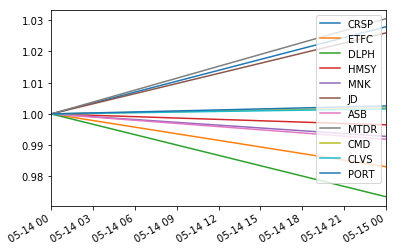

In [755]:
port_index.plot()

In [740]:
port_index.iloc[-1].describe()

count   11.00
mean     1.00
std      0.02
min      0.97
25%      0.99
50%      1.00
75%      1.01
max      1.03
Name: 2019-05-15 00:00:00, dtype: float64

In [741]:
# Backtesting experiment: What if we pick the best 10 longs everymonth?
stop_loss = False
long = False
max_loss = 0.3
as_of_date = -20
study_period = -10
holding_period = 20
# range = [study_period + as_of_date:as_of_date]
min_confidence = 0.8
max_class_rows = 50
pred_classes = [3, 4] if long else [0, 1]
period_range = list(range(-20, -pred_df.index.unique().shape[0], -holding_period))

super_list = []
symbol_list = []
for as_of_date in list(range(-20, -pred_df.index.unique().shape[0], -20)):
#     print(f'Predicting from {x} days ago')
    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes)
    symbols = list(most_freq_df.head(max_positions).symbol)
    if len(symbols) > 5:
        idx = clean_co_px.index.get_loc(study_dates[-1])
        prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        if stop_loss:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        exp = port_index.iloc[-1].describe()
        exp['offset_start'] = as_of_date
        exp['as_of_date'] = str(study_dates[-1])
        exp['study_period'] = study_period
        exp['end_date'] = str(port_index.index[-1])
        symbol_list.append(symbols)
        super_list.append(exp)
hist_ports = pd.concat(super_list, axis=1).T

Summary for 62 experiment SHORT periods
365 unique symbols


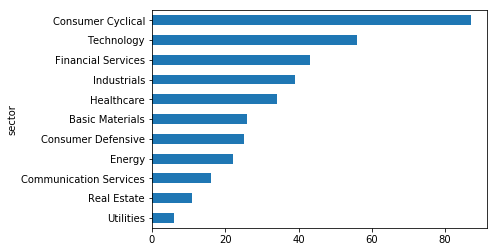

In [553]:
print(f'Summary for {len(period_range)} experiment {"LONG" if long else "SHORT"} periods')
unique_symbols = set(np.concatenate(symbol_list))
print(f'{len(unique_symbols)} unique symbols')
profile.loc[unique_symbols].groupby(by=['sector']).count().iloc[:,0].sort_values().plot.barh();

In [ ]:
hist_ports.sort_index(inplace=True)
years = (hist_ports.index[-1] - hist_ports.index[0]).days / 365
if long:
    mean_ret = pd.DataFrame()
    mean_ret['long'] = hist_ports['mean'].sort_index()
    mean_ret['long'].cumprod().plot();
    print(f'Long CAGR: {round((mean_ret["long"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
else:
    mean_ret['short'] = hist_ports['mean'].sort_index()
    mean_ret['short'].cumprod().plot();
    print(f'Short CAGR: {round((mean_ret["short"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret['ls'] = (mean_ret['long'] - mean_ret['short'] + 1)
    mean_ret.cumprod().plot()          
    print(f'L/S CAGR: {(mean_ret["ls"].cumprod().iloc[-1] ** (1/years) - 1)}')

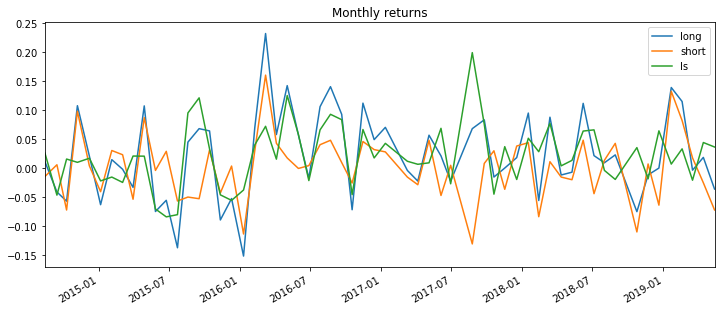

In [731]:
(mean_ret-1).plot(title='Monthly returns', figsize=(12,5))

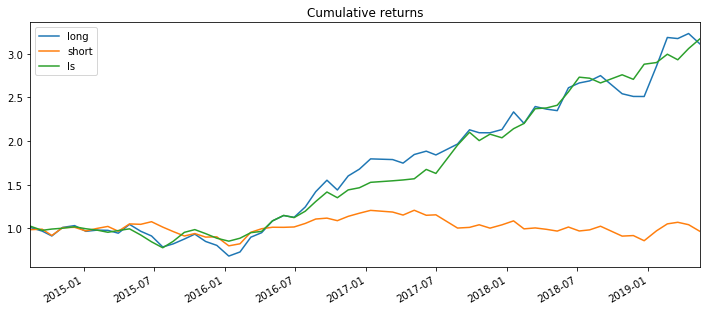

In [732]:
mean_ret.cumprod().plot(title='Cumulative returns', figsize=(12,5))

In [702]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


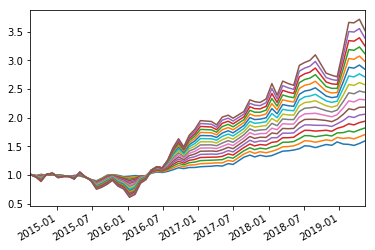

In [706]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
for l_w in series:
    monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
    super_list.append(mix_df)
    monthly_ret.cumprod().plot()
scenarios = pd.concat(super_list, axis=1).T
opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]

Expected return = 15.0% at 0.55 long 0.45 short


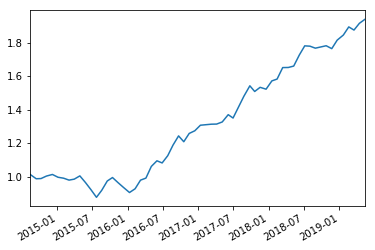

In [717]:
# expected long-term return at optimal L/S mix
monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
monthly_ret.cumprod().plot();

In [501]:
hist_ports.infer_objects()['mean'].describe()

count   59.00
mean     1.00
std      0.04
min      0.87
25%      0.98
50%      1.01
75%      1.03
max      1.07
Name: mean, dtype: float64

In [491]:
hist_ports.infer_objects().describe()

,count,mean,std,min,25%,50%,75%,max,offset_start,study_period
count,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00,59.00
mean,10.90,1.00,0.09,0.86,0.96,1.00,1.04,1.15,-640.68,-10.00
std,0.48,0.06,0.04,0.10,0.06,0.05,0.06,0.09,364.59,0.00
min,8.00,0.87,0.03,0.59,0.84,0.87,0.90,0.97,"-1,240.00",-10.00
25%,11.00,0.96,0.06,0.80,0.91,0.97,1.01,1.09,-950.00,-10.00
50%,11.00,1.01,0.08,0.87,0.97,1.00,1.05,1.14,-660.00,-10.00
75%,11.00,1.03,0.11,0.93,0.99,1.03,1.08,1.22,-330.00,-10.00
max,11.00,1.16,0.20,1.05,1.12,1.16,1.19,1.34,-20.00,-10.00


In [718]:
hist_ports.tail()

,count,mean,std,min,25%,50%,75%,max,offset_start,as_of_date,study_period,end_date
2019-01-22,11.00,1.13,0.07,1.03,1.10,1.12,1.16,1.31,-100.00,2018-12-21,-10,2019-01-22 00:00:00
2019-02-19,11.00,1.08,0.08,0.97,1.05,1.09,1.10,1.26,-80.00,2019-01-22,-10,2019-02-19 00:00:00
2019-03-18,8.00,1.02,0.07,0.95,0.98,1.01,1.02,1.18,-60.00,2019-02-19,-10,2019-03-18 00:00:00
2019-04-15,9.00,0.97,0.06,0.85,0.95,0.99,1.01,1.05,-40.00,2019-03-19,-10,2019-04-15 00:00:00
2019-05-14,11.00,0.93,0.11,0.74,0.86,0.92,1.01,1.12,-20.00,2019-04-16,-10,2019-05-14 00:00:00


#### Understand datasets

In [246]:
verbose = context['verbose']
ml_path, model_name = context['ml_path'], context['model_name']
trained_cols = context['trained_cols']    
test_size = context['test_size']    
look_ahead, look_back = context['look_ahead'], context['look_back']

train_tickers = list(train_on_winners(prices, context['tickers'], 10, 0.75).index)
context['tickers'] = train_tickers
print(f'Training on {len(context["tickers"])} companies')

Training on 249 companies


In [247]:
joined_df = pre_process_ds(context)

Sectors: 11, Industries: 77


0it [00:00, ?it/s]/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
4it [00:00, 15.29it/s]

9984.T missing profile, skipping


10it [00:00, 14.13it/s]

ABMD missing profile, skipping


125it [00:11, 12.66it/s]

JBT missing profile, skipping


138it [00:12, 12.26it/s]

LRCX missing profile, skipping


160it [00:14, 12.69it/s]

MU missing profile, skipping


178it [00:16, 12.07it/s]

ODFL missing profile, skipping


192it [00:17, 10.38it/s]

REGN missing profile, skipping


198it [00:18, 11.57it/s]

ROP missing profile, skipping


233it [00:21, 12.29it/s]

ULTI missing profile, skipping


249it [00:22,  9.85it/s]


In [248]:
# count NAs
print('NA', pd.value_counts(joined_df.isna().any(1)))
print('joined_df.shape', joined_df.shape)

NA False    820873
dtype: int64
joined_df.shape (820873, 29)


In [ ]:
# histogram of numeric columns
def plot_histograms(df):
    for c in numeric_cols(df): 
        df.loc[:, c].hist(); plt.title(c); plt.show()

plot_histograms(joined_df)

In [250]:
# calculation of forward returns
Y = clean_co_px.apply(lambda x: px_fwd_rets(x, '', periods=[20, 60, 120]))
Y = Y.rolling(int(np.mean(context['look_ahead']))).mean() # 
Y = Y[~(Y.isna().all(1))]
Y = Y.loc[joined_df.index.unique(), :]

# reshapes to include symbol in index in additional to date
Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
# somwhat repetitive with steps above but performs faster
Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
print('Y_df.shape', Y_df.shape)

# re-index processed df on storeDate and symbol to have similar indices
joined_df.index.set_names('storeDate', inplace=True)
joined_df.set_index(['symbol'], append=True, inplace=True)
print('joined_df.shape', joined_df.shape)

# add Y values to processed df fast without having to loop
joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

# joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
# joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

# discretize Y-variable
joined_df.dropna(subset=[y_col], inplace=True)
joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
print('joined_df.shape', joined_df.shape)
print(sample_wgts(joined_df[y_col]))

joined_df.dropna(subset=[y_col], inplace=True)
joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

days = len(joined_df.index.levels[0].unique())
print(f'Training for {days} dates, {round(days/252, 1)} years')

# joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
train_df = joined_df.reset_index(drop=True)
train_df.shape
      
# create training and test sets
X, y = train_df.drop(columns=y_col), train_df[y_col]
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break # just one split      

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (3726763, 1)
joined_df.shape (820873, 28)


/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (797839, 29)
neutral   0.48
long      0.18
bull      0.17
bear      0.10
short     0.06
Name: fwdReturn, dtype: float64
Training for 3603 dates, 14.3 years


In [251]:
pd.value_counts(joined_df.duplicated().sort_values())

False    797780
True         59
dtype: int64

In [252]:
joined_df.iloc[y_train.index].shape, joined_df.iloc[y_test.index].shape

((638271, 29), (159568, 29))

In [253]:
train_df = joined_df.iloc[y_train.index].reset_index()
test_df = joined_df.iloc[y_test.index].reset_index()

In [293]:
def count_dates(df, train_test, date_col, agg_ops):
    return df.iloc[train_test.index].reset_index().groupby(by=date_col).agg(agg_ops)

tt_df = pd.concat(
    [count_dates(joined_df, y_train, 'storeDate', ['count']).iloc[:, 0],
     count_dates(joined_df, y_test, 'storeDate', ['count']).iloc[:, 0]], 
    axis=1, sort=False)
tt_df = tt_df.droplevel(1,axis=1)
tt_df.columns = ['train', 'test']
tt_df.loc[px_close[bench].dropna().index, :].dropna(inplace=True)

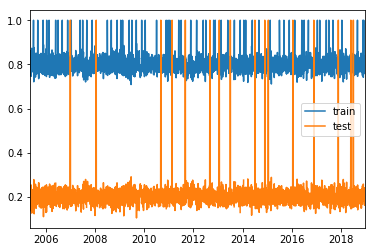

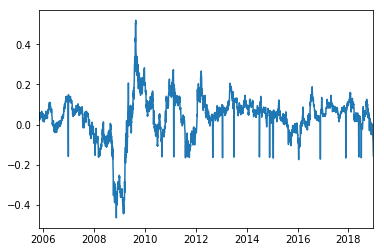

In [301]:
((tt_df.T / tt_df.sum(axis=1)).T).plot()
plt.show()
px_close.loc[tt_df.index, bench].pct_change(context['look_ahead']).dropna().plot();

In [291]:
print('Delta in Train/Test Class Distributions')
pd.value_counts(y_train) / pd.value_counts(y_train).sum() - pd.value_counts(y_test) / pd.value_counts(y_test).sum()

Delta in Train/Test Class Distributions


neutral    0.00
long      -0.00
bull      -0.00
bear      -0.00
short      0.00
Name: fwdReturn, dtype: float64

### Other experiments

#### Narrow training universe to outperformers

In [ ]:
narrow_list = list(train_on_winners(prices, tickers, 10, 0.75).index)
print(f'{len(narrow_list)} companies')

In [ ]:
q_df = quotes.loc[narrow_list, ['shortName', 'marketCap']]
p_df = profile.loc[narrow_list, ['sector', 'industry', 'country']]
joined_df = pd.concat([hist_return[narrow_list], q_df, p_df], axis=1)
joined_df.marketCap = joined_df.marketCap / 10**9

In [154]:
group_winners = joined_df.groupby(by=['sector']).describe(percentiles=[0.05, 0.95])
group_winners['totalReturn'].sort_values(by='mean')

,count,mean,std,min,5%,50%,95%,max
sector,,,,,,,,
Energy,2.00,4.58,0.24,4.42,4.43,4.58,4.74,4.75
Utilities,2.00,5.05,0.06,5.01,5.02,5.05,5.09,5.09
Real Estate,5.00,6.38,3.22,4.47,4.55,5.11,10.76,12.11
Technology,61.00,8.00,3.82,4.24,4.40,6.73,14.78,24.93
Industrials,43.00,8.06,3.97,4.20,4.64,6.62,15.83,21.18
Basic Materials,10.00,8.12,5.08,4.50,4.71,5.95,17.40,19.99
Consumer Defensive,8.00,8.58,3.66,5.44,5.50,7.83,14.58,16.51
Financial Services,23.00,8.78,8.27,4.30,4.33,5.99,25.30,39.83
Healthcare,41.00,9.15,6.34,4.31,4.51,7.11,25.19,32.68


In [155]:
group_winners['marketCap'].sort_values(by='mean')

,count,mean,std,min,5%,50%,95%,max
sector,,,,,,,,
Basic Materials,10.00,7.00,11.98,2.11,2.18,3.12,24.70,40.98
Utilities,2.00,14.68,6.27,10.25,10.69,14.68,18.67,19.11
Real Estate,5.00,16.46,14.13,4.43,5.05,13.79,35.47,40.27
Consumer Defensive,8.00,26.09,19.10,3.50,3.63,26.81,53.04,60.34
Energy,2.00,26.58,0.95,25.91,25.98,26.58,27.18,27.25
Healthcare,41.00,26.84,40.72,0.79,2.38,13.21,94.30,227.73
Industrials,43.00,27.12,39.13,1.57,2.87,11.62,118.51,202.41
Communication Services,4.00,28.42,38.79,2.59,2.62,13.18,75.53,84.71
Financial Services,23.00,42.27,85.34,1.72,2.77,13.11,234.51,351.32


In [156]:
joined_df.groupby(by=['industry']).agg(['count', 'mean'])['totalReturn'].sort_values(by='count').tail(10)

,count,mean
industry,,
Specialty Retail,7,15.33
Health Care Plans,7,9.10
Internet Content & Information,8,9.18
Biotechnology,8,11.22
Semiconductors,9,7.59
Diversified Industrials,9,6.22
Medical Instruments & Supplies,9,6.75
Diagnostics & Research,10,8.74
Business Services,11,6.45


In [157]:
joined_df.loc[joined_df.industry.isin(['Diagnostics & Research']), :]

,totalReturn,shortName,marketCap,sector,industry,country
symbol,,,,,,
A,4.51,"Agilent Technologies, Inc.",24.32,Healthcare,Diagnostics & Research,United States
BRKR,4.85,Bruker Corporation,6.64,Healthcare,Diagnostics & Research,United States
DHR,4.66,Danaher Corporation,94.30,Healthcare,Diagnostics & Research,United States
DXCM,27.91,"DexCom, Inc.",10.76,Healthcare,Diagnostics & Research,United States
IDXX,11.33,"IDEXX Laboratories, Inc.",21.14,Healthcare,Diagnostics & Research,United States
ILMN,7.40,"Illumina, Inc.",46.96,Healthcare,Diagnostics & Research,United States
MTD,8.74,"Mettler-Toledo International, I",18.39,Healthcare,Diagnostics & Research,United States
NEOG,7.28,Neogen Corporation,3.17,Healthcare,Diagnostics & Research,United States
PKI,4.35,"PerkinElmer, Inc.",10.34,Healthcare,Diagnostics & Research,United States


#### More Sector analysis

In [122]:
tgt_sectors = [
    'Technology', 'Communication Services', 
    'Healthcare', 'Consumer Cyclical', 'Consumer Defensive', 'Industrials']
size_df = get_focus_tickers(quotes, profile, tgt_sectors)
size_df.groupby('industry').sum()['marketCap'].sort_values()

industry
Engineering & Construction              83.82
Packaging & Containers                  90.67
Medical Care                            93.75
Scientific & Technical Instruments     107.24
Electronic Components                  124.90
Leisure                                252.71
Biotechnology                          286.58
Medical Instruments & Supplies         287.91
Restaurants                            344.67
Business Services                      386.81
Communication Equipment                420.76
Information Technology Services        430.11
Diagnostics & Research                 447.77
Medical Devices                        500.25
Media - Diversified                    522.33
Packaged Foods                         569.99
Household & Personal Products          648.31
Aerospace & Defense                    681.69
Diversified Industrials                795.47
Semiconductors                       1,195.61
Telecom Services                     1,263.18
Software - Infrastructure

In [123]:
size_df.groupby(['size', 'sector', ]).count()['marketCap']
size_df.groupby('size').count()['marketCap']

size
micro      0
small     32
mid      229
large    237
mega      10
Name: marketCap, dtype: int64

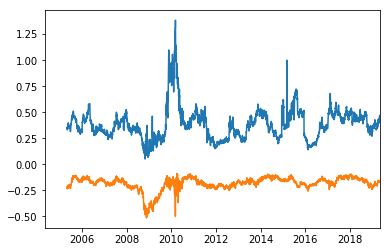

In [94]:
# Average increase and decrease over a give time period
prices = px_close.dropna(subset=[bench])[tickers]
excl_tickers = list(prices.iloc[-1].isna().loc[prices.iloc[-1].isna().values].index)
prices = prices[excl(prices.columns, excl_tickers)]

look_back = context['look_back']
prices.pct_change(look_back).where(prices.pct_change(look_back) > 0).mean(1).plot()
prices.pct_change(look_back).where(prices.pct_change(look_back) < 0).mean(1).plot()

In [95]:
get_return_intervals(prices, 120, tresholds=[0.25, 0.75])

(-inf,
 -0.18970860540866852,
 -0.12610292434692383,
 0.18030300736427307,
 0.3123534917831421,
 inf)

#### Date and minute based time analysis

In [ ]:
freq = '1d'

In [ ]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

In [ ]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

In [ ]:
df.index.date

In [ ]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

In [ ]:
df.tail(5)

In [ ]:
freq = '1d'

In [ ]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

In [ ]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

In [ ]:
f'Ticker: {ticker}'

In [ ]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

#### Old code

In [ ]:
# test distribution of Y variable
tickers = list(mu.sample_sector_tickers(eqty_symbols, profile, sectors, 50).index)
context['grid_search'] = False
context['tickers'] = tickers
context['train_model'] = True

df_large = create_ds(context)

df = df_large.copy()
df.dropna(subset=[y_col], inplace=True)
df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
df.dropna(subset=[y_col], inplace=True) # no nas in y_col
df[y_col] = df[y_col].astype(str) # class as string
sample_wgts(df[y_col])

pred_X, X_traxin, X_test, y_train, y_test = pre_process_ds(df_large, context)
pd.value_counts(discret_rets(df_large.fwdReturn, cut_range, fwd_ret_labels)).sum()
pd.value_counts(pd.concat([y_train, y_test], axis=0)).sum()

In [ ]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [ ]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [ ]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [ ]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [ ]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [ ]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)